In [1]:
# -*- coding: utf-8 -*-
"""Untitled0.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1YELWdurMaSt39Kf4PjYKtCE7QRuOmWf5
"""

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
andrewmvd_car_plate_detection_path = kagglehub.dataset_download('andrewmvd/car-plate-detection')

print('Data source import complete.')

# Install necessary dependencies
!pip install ultralytics torch torchvision pytesseract gdown

from ultralytics import YOLO
import os
import xml.etree.ElementTree as xet
import glob
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from pathlib import Path
import cv2
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Dataset Path
path = kagglehub.dataset_download("andrewmvd/car-plate-detection")

# Define paths for XML and Image files
xml_files_path = glob.glob(f'{path}/annotations/*.xml')
image_files_path = glob.glob(f'{path}/images/**/*.png')

# Initialize labels_dict to store image data and bounding box coordinates
labels_dict = {'filepath': [], 'xmin': [], 'xmax': [], 'ymin': [], 'ymax': []}

# Parse XML annotations and store corresponding data
for xml_filename in xml_files_path:
    info = xet.parse(xml_filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')

    # Extract bounding box coordinates
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    # Adjust image filename and store data in labels_dict
    image_filename = xml_filename.replace('annotations', 'images').replace('.xml', '.png')
    labels_dict['filepath'].append(image_filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

# Define save paths in Google Drive
drive_output_dir = '/content/drive/MyDrive/license_plate_recognition'
os.makedirs(f'{drive_output_dir}/images/train', exist_ok=True)
os.makedirs(f'{drive_output_dir}/images/val', exist_ok=True)
os.makedirs(f'{drive_output_dir}/labels/train', exist_ok=True)
os.makedirs(f'{drive_output_dir}/labels/val', exist_ok=True)

def convert_bbox_to_yolo_format(bbox, image_width, image_height):
    xmin, xmax, ymin, ymax = bbox
    x_center = (xmin + xmax) / 2 / image_width
    y_center = (ymin + ymax) / 2 / image_height
    width = (xmax - xmin) / image_width
    height = (ymax - ymin) / image_height
    return x_center, y_center, width, height

image_paths = labels_dict['filepath']
labels = list(zip(labels_dict['xmin'], labels_dict['xmax'], labels_dict['ymin'], labels_dict['ymax']))

train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

for dataset_type, image_paths, labels in [('train', train_image_paths, train_labels), ('val', val_image_paths, val_labels)]:
    for image_path, bbox in zip(image_paths, labels):
        if not os.path.exists(image_path):  # Ensure image exists before processing
            print(f"Warning: Image {image_path} not found!")
            continue

        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not read image {image_path}")
            continue

        h, w, _ = img.shape
        x_center, y_center, width, height = convert_bbox_to_yolo_format(bbox, w, h)
        label_filename = Path(image_path).stem + '.txt'
        cv2.imwrite(f'{drive_output_dir}/images/{dataset_type}/{Path(image_path).name}', img)
        with open(f'{drive_output_dir}/labels/{dataset_type}/{label_filename}', 'w') as f:
            f.write(f'0 {x_center} {y_center} {width} {height}\n')

# Update YAML configuration
yaml_content = f"""
train: {drive_output_dir}/images/train
val: {drive_output_dir}/images/val

nc: 1
names: ['license_plate']
"""

with open(f"{drive_output_dir}/license_plate.yaml", "w") as yaml_file:
    yaml_file.write(yaml_content)

# Check if dataset has been processed correctly
print("Train Images:", os.listdir(f'{drive_output_dir}/images/train'))
print("Val Images:", os.listdir(f'{drive_output_dir}/images/val'))

# Train YOLO model
model = YOLO("yolov8n.pt")
model.train(data=f"{drive_output_dir}/license_plate.yaml", epochs=50, batch=16, imgsz=640, workers=4)

# Save trained model to Google Drive
model_path = f"{drive_output_dir}/license_plate_model.pt"
model.save(model_path)
print(f"Model saved at {model_path}")


100%|██████████| 203M/203M [00:04<00:00, 50.9MB/s]

Extracting files...


Data source import complete.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.6/922.6 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlin

100%|██████████| 6.25M/6.25M [00:00<00:00, 190MB/s]


Ultralytics 8.3.86 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/license_plate_recognition/license_plate.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

100%|██████████| 755k/755k [00:00<00:00, 94.6MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/MyDrive/license_plate_recognition/labels/train.cache... 346 images, 0 backgrounds, 0 corrupt: 100%|██████████| 346/346 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/license_plate_recognition/labels/val.cache... 87 images, 0 backgrounds, 0 corrupt: 100%|██████████| 87/87 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G       1.48      2.957      1.282         12        640: 100%|██████████| 22/22 [04:37<00:00, 12.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:20<00:00,  6.74s/it]

                   all         87         87    0.00326      0.977      0.606      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.422      1.975      1.196         15        640: 100%|██████████| 22/22 [04:27<00:00, 12.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.54s/it]

                   all         87         87     0.0109      0.713      0.219      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.449       1.94      1.236         28        640: 100%|██████████| 22/22 [04:25<00:00, 12.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:25<00:00,  8.43s/it]

                   all         87         87      0.682      0.161      0.209      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.478      1.784      1.298         18        640: 100%|██████████| 22/22 [04:28<00:00, 12.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.27s/it]

                   all         87         87      0.714      0.517      0.557      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.519      1.825      1.297         17        640: 100%|██████████| 22/22 [04:23<00:00, 11.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.47s/it]

                   all         87         87      0.868      0.607      0.638       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G       1.53      1.641      1.277         18        640: 100%|██████████| 22/22 [04:27<00:00, 12.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.46s/it]

                   all         87         87      0.805      0.663      0.713      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.479      1.436      1.295         16        640: 100%|██████████| 22/22 [04:29<00:00, 12.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.15s/it]

                   all         87         87      0.749      0.754      0.817      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.496      1.427      1.284         18        640: 100%|██████████| 22/22 [04:24<00:00, 12.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.50s/it]

                   all         87         87      0.899      0.621      0.791      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.456      1.297      1.267         27        640: 100%|██████████| 22/22 [04:24<00:00, 12.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.47s/it]

                   all         87         87      0.783      0.793      0.823      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.465      1.308      1.259         18        640: 100%|██████████| 22/22 [04:24<00:00, 12.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.10s/it]

                   all         87         87       0.83      0.785      0.869        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.457      1.244      1.245         20        640: 100%|██████████| 22/22 [04:27<00:00, 12.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.07s/it]

                   all         87         87      0.917      0.758      0.881      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.384      1.137      1.221         20        640: 100%|██████████| 22/22 [04:26<00:00, 12.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.21s/it]

                   all         87         87      0.732      0.846      0.858      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G        1.4      1.139      1.248         23        640: 100%|██████████| 22/22 [04:58<00:00, 13.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.11s/it]

                   all         87         87       0.86      0.845      0.877       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.324      1.097      1.209         21        640: 100%|██████████| 22/22 [04:26<00:00, 12.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.16s/it]

                   all         87         87      0.909      0.805      0.906      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.349       1.04       1.19         21        640: 100%|██████████| 22/22 [04:25<00:00, 12.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.18s/it]

                   all         87         87      0.876      0.895      0.942      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.365      1.025      1.229         15        640: 100%|██████████| 22/22 [04:27<00:00, 12.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.47s/it]

                   all         87         87      0.936      0.841      0.926      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.289     0.9504      1.181         19        640: 100%|██████████| 22/22 [04:24<00:00, 12.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.45s/it]

                   all         87         87      0.882      0.948      0.948      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.283     0.9518      1.181         23        640: 100%|██████████| 22/22 [04:22<00:00, 11.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.07s/it]

                   all         87         87      0.837      0.885      0.909      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.332      0.946      1.212         17        640: 100%|██████████| 22/22 [04:24<00:00, 12.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.09s/it]

                   all         87         87      0.878      0.914      0.929      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.296     0.9232      1.191         20        640: 100%|██████████| 22/22 [04:24<00:00, 12.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.15s/it]

                   all         87         87      0.907      0.894       0.92      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.279     0.8792      1.156         17        640: 100%|██████████| 22/22 [04:22<00:00, 11.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:20<00:00,  6.70s/it]

                   all         87         87      0.856       0.89      0.903      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.285     0.8983      1.159         23        640: 100%|██████████| 22/22 [04:22<00:00, 11.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.99s/it]

                   all         87         87      0.938      0.864      0.956      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.257     0.8936      1.142         23        640: 100%|██████████| 22/22 [04:24<00:00, 12.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.08s/it]

                   all         87         87      0.805      0.908      0.934      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.251     0.8398      1.188         20        640: 100%|██████████| 22/22 [04:21<00:00, 11.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.47s/it]

                   all         87         87       0.86      0.816      0.896      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.217     0.8444      1.141         20        640: 100%|██████████| 22/22 [04:20<00:00, 11.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.16s/it]

                   all         87         87      0.848      0.839      0.892      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G       1.17     0.8504      1.126         24        640: 100%|██████████| 22/22 [04:21<00:00, 11.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.44s/it]

                   all         87         87      0.865      0.883      0.903      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.216     0.8206      1.162         15        640: 100%|██████████| 22/22 [04:23<00:00, 11.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.40s/it]

                   all         87         87      0.878      0.862      0.906      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.215      0.831      1.152         13        640: 100%|██████████| 22/22 [04:21<00:00, 11.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.09s/it]

                   all         87         87      0.864      0.851      0.907       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      1.192     0.7909      1.143         23        640: 100%|██████████| 22/22 [04:25<00:00, 12.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.24s/it]

                   all         87         87      0.851      0.916      0.933      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      1.192     0.7784      1.119         22        640: 100%|██████████| 22/22 [04:26<00:00, 12.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.07s/it]

                   all         87         87      0.919      0.874      0.959      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.197     0.7581      1.131         18        640: 100%|██████████| 22/22 [04:25<00:00, 12.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.40s/it]

                   all         87         87      0.918      0.905      0.965      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.137     0.7259      1.117         16        640: 100%|██████████| 22/22 [04:20<00:00, 11.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.41s/it]

                   all         87         87      0.924      0.862      0.942      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.161     0.7351       1.11         21        640: 100%|██████████| 22/22 [04:22<00:00, 11.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.31s/it]

                   all         87         87      0.851      0.862      0.903      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.122     0.6972      1.105         18        640: 100%|██████████| 22/22 [04:22<00:00, 11.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.17s/it]

                   all         87         87      0.891      0.908      0.934      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G       1.16     0.7098      1.129         14        640: 100%|██████████| 22/22 [04:23<00:00, 11.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.48s/it]

                   all         87         87      0.915      0.897      0.948      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G      1.122     0.7116      1.105         15        640: 100%|██████████| 22/22 [04:23<00:00, 11.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.05s/it]

                   all         87         87      0.897       0.92      0.943      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G       1.11     0.6936      1.112         21        640: 100%|██████████| 22/22 [04:23<00:00, 12.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.13s/it]

                   all         87         87      0.906      0.862      0.929      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      1.094     0.6678      1.073         20        640: 100%|██████████| 22/22 [04:25<00:00, 12.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.66s/it]

                   all         87         87      0.901      0.943      0.963      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      1.096     0.6739      1.106         23        640: 100%|██████████| 22/22 [04:26<00:00, 12.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.14s/it]

                   all         87         87      0.912      0.949      0.954       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G      1.086     0.6451      1.093         15        640: 100%|██████████| 22/22 [04:24<00:00, 12.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.25s/it]

                   all         87         87      0.925      0.874      0.933      0.576


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      1.047     0.6612      1.088         10        640: 100%|██████████| 22/22 [04:22<00:00, 11.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.08s/it]

                   all         87         87      0.903      0.839      0.927      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G      1.052     0.6204      1.069         10        640: 100%|██████████| 22/22 [04:22<00:00, 11.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.24s/it]

                   all         87         87      0.939      0.878      0.951      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G      1.025     0.6133      1.073         10        640: 100%|██████████| 22/22 [04:21<00:00, 11.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.01s/it]

                   all         87         87      0.931      0.862      0.946      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      1.018     0.6099      1.072         10        640: 100%|██████████| 22/22 [04:16<00:00, 11.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.37s/it]

                   all         87         87      0.906      0.839      0.917      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G      1.006     0.6087      1.043         10        640: 100%|██████████| 22/22 [04:18<00:00, 11.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.22s/it]

                   all         87         87      0.901      0.834      0.914      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.9712     0.5672      1.034         10        640: 100%|██████████| 22/22 [04:18<00:00, 11.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.24s/it]

                   all         87         87      0.895      0.862      0.928      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.9868     0.5794      1.051         10        640: 100%|██████████| 22/22 [04:20<00:00, 11.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.03s/it]

                   all         87         87      0.906      0.851      0.927      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.9684     0.5764      1.051         10        640: 100%|██████████| 22/22 [04:18<00:00, 11.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.98s/it]

                   all         87         87      0.938      0.873      0.956      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.9382     0.5536      1.036         10        640: 100%|██████████| 22/22 [04:18<00:00, 11.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.56s/it]

                   all         87         87      0.925      0.852      0.951      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.9248     0.5471      1.047         10        640: 100%|██████████| 22/22 [04:20<00:00, 11.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.50s/it]

                   all         87         87      0.921      0.874      0.942      0.582



50 epochs completed in 3.947 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.86 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.73s/it]


                   all         87         87      0.901      0.943      0.962      0.603
Speed: 1.8ms preprocess, 175.9ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/train
Model saved at /content/drive/MyDrive/license_plate_recognition/license_plate_model.pt


In [2]:
from google.colab import drive
import cv2
import os
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')

# Paths to dataset
train_images_dir = "/content/drive/MyDrive/license_plate_recognition/images/train"
val_images_dir = "/content/drive/MyDrive/license_plate_recognition/images/val"
train_labels_dir = "/content/drive/MyDrive/license_plate_recognition/labels/train"
val_labels_dir = "/content/drive/MyDrive/license_plate_recognition/labels/val"

# Output directories
output_base = "/content/drive/MyDrive/license_plate_recognition/processed_dataset"
os.makedirs(output_base, exist_ok=True)

for dataset in ['train', 'val']:
    os.makedirs(f"{output_base}/{dataset}", exist_ok=True)
    os.makedirs(f"{output_base}/{dataset}/cropped", exist_ok=True)
    os.makedirs(f"{output_base}/{dataset}/resized", exist_ok=True)
    os.makedirs(f"{output_base}/{dataset}/normalized", exist_ok=True)
    os.makedirs(f"{output_base}/{dataset}/grayscale", exist_ok=True)
    os.makedirs(f"{output_base}/{dataset}/denoised", exist_ok=True)
    os.makedirs(f"{output_base}/{dataset}/binary", exist_ok=True)
    os.makedirs(f"{output_base}/{dataset}/segmented", exist_ok=True)  # For character segmentation

# Function to preprocess images
def preprocess_images(image_dir, label_dir, dataset):
    image_filenames = os.listdir(image_dir)

    for img_file in image_filenames:
        image_path = os.path.join(image_dir, img_file)
        label_path = os.path.join(label_dir, img_file.replace(".png", ".txt"))

        if not os.path.exists(label_path):
            continue

        # Read image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        # Read bounding box from label file
        with open(label_path, "r") as f:
            data = f.readline().split()
            _, x_center, y_center, width, height = map(float, data)

        # Convert YOLO format to pixel values
        x_min = int((x_center - width / 2) * w)
        y_min = int((y_center - height / 2) * h)
        x_max = int((x_center + width / 2) * w)
        y_max = int((y_center + height / 2) * h)

        cropped_plate = img[y_min:y_max, x_min:x_max]

        if cropped_plate.size == 0:
            continue

        # Save cropped license plate
        cropped_path = f"{output_base}/{dataset}/cropped/{img_file}"
        cv2.imwrite(cropped_path, cv2.cvtColor(cropped_plate, cv2.COLOR_RGB2BGR))

        # Resize image
        resized_plate = cv2.resize(cropped_plate, (128, 64))
        resized_path = f"{output_base}/{dataset}/resized/{img_file}"
        cv2.imwrite(resized_path, resized_plate)

        # Normalize image (scale pixel values between 0 and 1)
        normalized_plate = resized_plate.astype(np.float32) / 255.0
        normalized_path = f"{output_base}/{dataset}/normalized/{img_file}"
        cv2.imwrite(normalized_path, (normalized_plate * 255).astype(np.uint8))

        # Convert to grayscale
        gray_plate = cv2.cvtColor(resized_plate, cv2.COLOR_RGB2GRAY)
        gray_path = f"{output_base}/{dataset}/grayscale/{img_file}"
        cv2.imwrite(gray_path, gray_plate)

        # Denoising
        denoised_plate = cv2.fastNlMeansDenoising(gray_plate, None, 30, 7, 21)
        denoised_path = f"{output_base}/{dataset}/denoised/{img_file}"
        cv2.imwrite(denoised_path, denoised_plate)

        # Apply binary thresholding
        _, binary_plate = cv2.threshold(denoised_plate, 127, 255, cv2.THRESH_BINARY)
        binary_path = f"{output_base}/{dataset}/binary/{img_file}"
        cv2.imwrite(binary_path, binary_plate)

        # Character Segmentation
        segment_characters(binary_plate, dataset, img_file)

        print(f"✅ Processed: {img_file}")

# Function for character segmentation
def segment_characters(binary_img, dataset, img_file):
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    character_folder = f"{output_base}/{dataset}/segmented/{img_file.split('.')[0]}"
    os.makedirs(character_folder, exist_ok=True)

    char_count = 0
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        if w > 5 and h > 10:  # Filter out small contours
            char_img = binary_img[y:y+h, x:x+w]
            char_path = f"{character_folder}/char_{char_count}.png"
            cv2.imwrite(char_path, char_img)
            char_count += 1

    print(f"✅ Segmented {char_count} characters for {img_file}")

# Run preprocessing on train and val datasets
preprocess_images(train_images_dir, train_labels_dir, 'train')
preprocess_images(val_images_dir, val_labels_dir, 'val')

print("✅ All license plates processed and saved in Google Drive!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Segmented 1 characters for Cars329.png
✅ Processed: Cars329.png
✅ Segmented 1 characters for Cars32.png
✅ Processed: Cars32.png
✅ Segmented 2 characters for Cars189.png
✅ Processed: Cars189.png
✅ Segmented 2 characters for Cars21.png
✅ Processed: Cars21.png
✅ Segmented 2 characters for Cars263.png
✅ Processed: Cars263.png
✅ Segmented 0 characters for Cars300.png
✅ Processed: Cars300.png
✅ Segmented 1 characters for Cars38.png
✅ Processed: Cars38.png
✅ Segmented 2 characters for Cars383.png
✅ Processed: Cars383.png
✅ Segmented 2 characters for Cars80.png
✅ Processed: Cars80.png
✅ Segmented 6 characters for Cars315.png
✅ Processed: Cars315.png
✅ Segmented 1 characters for Cars319.png
✅ Processed: Cars319.png
✅ Segmented 4 characters for Cars279.png
✅ Processed: Cars279.png
✅ Segmented 1 characters for Cars355.png
✅ Processed: Cars355.png
✅ Segmented 1 charact

In [7]:
import cv2
import os
import numpy as np
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Paths
input_folder = "/content/drive/MyDrive/license_plate_recognition/processed_dataset/train/binary"
output_folder = "/content/drive/MyDrive/license_plate_recognition/segmented_characters"

# Create output directory if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Process each binary image
for img_file in os.listdir(input_folder):
    img_path = os.path.join(input_folder, img_file)

    # Read binary image
    binary_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Find contours of characters
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    char_count = 0  # Character counter

    # Sort contours left to right
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        # Filter out small contours (noise)
        if w > 10 and h > 30:
            char_img = binary_img[y:y+h, x:x+w]
            char_img = cv2.resize(char_img, (28, 28))  # Resize for CNN input

            # Save character image
            char_filename = f"{img_file.replace('.png', '')}_char{char_count}.png"
            char_path = os.path.join(output_folder, char_filename)
            cv2.imwrite(char_path, char_img)

            char_count += 1

    print(f"✅ Segmented {char_count} characters from {img_file}")

print("✅ All character segmentation completed and saved in Google Drive!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Segmented 1 characters from Cars329.png
✅ Segmented 1 characters from Cars32.png
✅ Segmented 1 characters from Cars189.png
✅ Segmented 2 characters from Cars21.png
✅ Segmented 1 characters from Cars263.png
✅ Segmented 0 characters from Cars300.png
✅ Segmented 1 characters from Cars38.png
✅ Segmented 1 characters from Cars383.png
✅ Segmented 1 characters from Cars80.png
✅ Segmented 3 characters from Cars315.png
✅ Segmented 1 characters from Cars319.png
✅ Segmented 1 characters from Cars279.png
✅ Segmented 1 characters from Cars355.png
✅ Segmented 1 characters from Cars351.png
✅ Segmented 1 characters from Cars405.png
✅ Segmented 1 characters from Cars121.png
✅ Segmented 1 characters from Cars56.png
✅ Segmented 1 characters from Cars228.png
✅ Segmented 1 characters from Cars39.png
✅ Segmented 2 characters from Cars143.png
✅ Segmented 2 characters from Cars298

In [10]:
import os
import shutil
import re

dataset_path = "/content/drive/MyDrive/license_plate_recognition/segmented_characters"

# Create a new organized dataset directory
organized_dataset_path = "/content/drive/MyDrive/license_plate_recognition/organized_characters"
os.makedirs(organized_dataset_path, exist_ok=True)

# Process each image
for filename in os.listdir(dataset_path):
    match = re.search(r'_char(\d+)\.png$', filename)
    if match:
        char_label = match.group(1)  # Extract character label

        # Create directory for the character if it doesn't exist
        char_dir = os.path.join(organized_dataset_path, char_label)
        os.makedirs(char_dir, exist_ok=True)

        # Move file to the corresponding folder
        old_path = os.path.join(dataset_path, filename)
        new_path = os.path.join(char_dir, filename)
        shutil.move(old_path, new_path)

print("Dataset organized successfully!")


Dataset organized successfully!


In [11]:
dataset_path = "/content/drive/MyDrive/license_plate_recognition/organized_characters"


In [12]:
import os

dataset_path = "/content/drive/MyDrive/license_plate_recognition/organized_characters"
categories = os.listdir(dataset_path)
print("Classes found:", categories)


Classes found: ['0', '1', '2', '3', '4', '5', '6', '7']


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define batch size and image dimensions
batch_size = 32
img_height, img_width = 64, 64

# Apply data augmentation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)


Found 285 images belonging to 8 classes.
Found 67 images belonging to 8 classes.


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),  # Ensures the correct shape before passing to Dense layers

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')  # 8 classes as detected in your dataset
])

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
model.fit(train_generator, validation_data=val_generator, epochs=15)


Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 361ms/step - accuracy: 0.5800 - loss: 1.3860 - val_accuracy: 0.8806 - val_loss: 0.5330
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - accuracy: 0.8228 - loss: 0.7408 - val_accuracy: 0.8806 - val_loss: 0.4329
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - accuracy: 0.8299 - loss: 0.6945 - val_accuracy: 0.8806 - val_loss: 0.4058
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 405ms/step - accuracy: 0.8453 - loss: 0.6409 - val_accuracy: 0.8806 - val_loss: 0.4397
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 311ms/step - accuracy: 0.8279 - loss: 0.6199 - val_accuracy: 0.8806 - val_loss: 0.3552
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 266ms/step - accuracy: 0.8373 - loss: 0.6228 - val_accuracy: 0.8806 - val_loss: 0.3481
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - accuracy: 0.8510 - loss: 0.4855 - val_accuracy: 0.8955 - val_loss: 0.3213
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 340ms/step - accuracy: 0.8391 - loss: 0.5215 - val_accuracy: 0.8955 - val_loss:

In [17]:
import keras.saving
keras.saving.save_model(model, 'model.keras')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

📂 Found 346 files in '/content/drive/My Drive/license_plate_recognition/images/train'. Listing first 5 files:
['Cars329.png', 'Cars32.png', 'Cars189.png', 'Cars21.png', 'Cars263.png']

📂 Found 295 files in '/content/drive/My Drive/license_plate_recognition/organized_characters/0'. Listing first 5 files:
['Cars329_char0.png', 'Cars32_char0.png', 'Cars189_char0.png', 'Cars21_char0.png', 'Cars263_char0.png']

📸 Showing Sample Train Images:


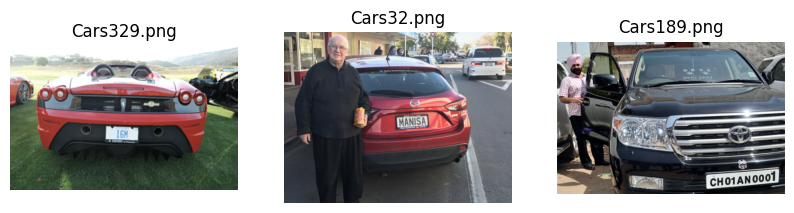


🔠 Showing Sample Character Images (Class 0):


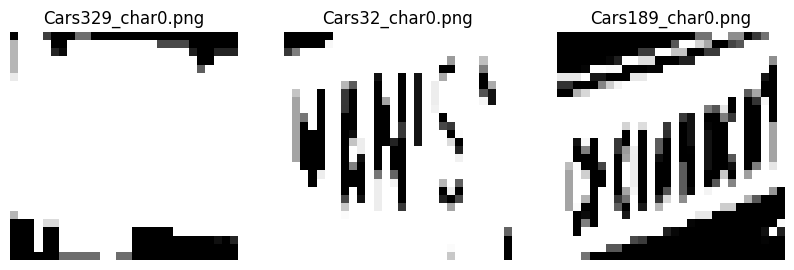

In [22]:
import os
import cv2
import matplotlib.pyplot as plt
from google.colab import drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define Paths
BASE_PATH = "/content/drive/My Drive/license_plate_recognition/"
IMAGES_PATH = os.path.join(BASE_PATH, "images/train")  # Update if needed
CHARACTERS_PATH = os.path.join(BASE_PATH, "organized_characters/0")  # Testing '0' class

# Step 3: List Files in Folders
def list_files(directory, num_files=5):
    if os.path.exists(directory):
        files = os.listdir(directory)
        print(f"\n📂 Found {len(files)} files in '{directory}'. Listing first {num_files} files:")
        print(files[:num_files])
        return files
    else:
        print(f"❌ Path not found: {directory}")
        return []

image_files = list_files(IMAGES_PATH)
char_files = list_files(CHARACTERS_PATH)

# Step 4: Display Some Sample Images
def show_images(directory, files, num=3):
    plt.figure(figsize=(10, 5))
    for i, file in enumerate(files[:num]):
        img_path = os.path.join(directory, file)
        img = cv2.imread(img_path)  # Read image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib
        plt.subplot(1, num, i+1)
        plt.imshow(img)
        plt.title(file)
        plt.axis("off")
    plt.show()

if image_files:
    print("\n📸 Showing Sample Train Images:")
    show_images(IMAGES_PATH, image_files)

if char_files:
    print("\n🔠 Showing Sample Character Images (Class 0):")
    show_images(CHARACTERS_PATH, char_files)


In [24]:
def show_images(directory, files, num=3):
    plt.figure(figsize=(10, 5))
    for i, file in enumerate(files[:num]):
        img_path = os.path.join(directory, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
        plt.subplot(1, num, i+1)
        plt.imshow(img, cmap='gray')  # Display as grayscale
        plt.title(file)
        plt.axis("off")
    plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


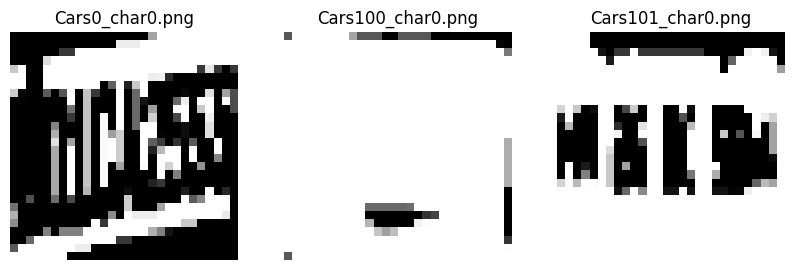

TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.

In [26]:
from google.colab import drive
drive.mount('/content/drive')
import os
import cv2
import matplotlib.pyplot as plt

# Set the correct path to your dataset in Google Drive
base_dir = "/content/drive/My Drive/license_plate_recognition/organized_characters/0"  # Modify if needed

def show_images(directory, files, num=3):
    plt.figure(figsize=(10, 5))
    for i, file in enumerate(files[:num]):
        img_path = os.path.join(directory, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
        plt.subplot(1, num, i+1)
        plt.imshow(img, cmap='gray')  # Display as grayscale
        plt.title(file)
        plt.axis("off")
    plt.show()

# Get image files in the directory
files = sorted(os.listdir(base_dir))[:10]  # Change number if needed
show_images(base_dir, files)
import pytesseract

# Test OCR on one sample image
img_path = os.path.join(base_dir, files[0])  # Modify if needed
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Extract text
text = pytesseract.image_to_string(img, config='--psm 10')
print(f"Detected text: {text}")

